## Load Data

In [49]:
from __future__ import print_function  # Python 2 and 3
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from math import log, exp
from sklearn import linear_model
#This is to disable the warning info
pd.options.mode.chained_assignment = None  # default='warn'

In [50]:
##the functions created in preprocess module
from preprocess import impute_multi_1,impute_multi_2, label_en
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [51]:
#This function works to generate CSV
def model_to_csv(model, x_test, test_ID, csv_name):
    y = model.predict(x_test)
    y = pd.Series([(exp(y[i]) + x_test['MiscVal'][i]) for i in range(len(x_test))],name='SalePrice')
    y_out = pd.concat([test_ID, y], axis=1)
    y_out.to_csv('%s' % csv_name, index = False)

#This is the log transition for any features
def log_tran(df, li):
    for col in li:
        df[col] = [log(x) if x>0 else 0 for x in df[col]]

#This is the sqrt tranforma for some area feature
def sqrt_tran(df, li):
    for col in li:
        df[col] = [x**0.5 for x in df[col]]

#This function drop the dumified features with minority num <73
def drop_minor(df):
    drop_list=[]
    for col in one_hot_df.columns:
        if len(one_hot_df[col].unique()) == 2 :
            if ((one_hot_df.groupby(col).count()['LotFrontage'][0]>73) &
                (one_hot_df.groupby(col).count()['LotFrontage'][1]>73)):
                continue
            else:
                drop_list.append(col)
        else:
            continue
    return drop_list

In [52]:
#Load files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']
# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

#create train_raw for use in differenct models
y_train_raw = train_df['SalePrice']
x_train_raw = train_df.drop('SalePrice', axis=1)
x_test_raw = test_df.copy()
#delete the loaded csv files
del train_df, test_df

#combine train and test data. all_data 
all_data = pd.concat([x_train_raw, x_test_raw])
all_data.shape

(2919, 79)

#############################################
# Multi Linear Ridge Model_1 #
#############################################

In [ ]:
#call the impute function in process module
one_hot_df = impute_multi_1(all_data)

#label encode the ordered category 
one_hot_df = label_en(one_hot_df)
one_hot_df.head()

In [ ]:
#use one_hot encoding to dummify all the category data
one_hot_df = pd.get_dummies(one_hot_df, drop_first=True, dummy_na=True)

In [ ]:
#list of features that needs to be transformed by log
log_tran_list = ['LotArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1',
                 'GarageArea', 'LowQualFinSF','TotalBsmtFinSF']
##transform the features us created func
log_tran(one_hot_df, log_tran_list)

#list of features that needs to be transformed sqrt.
sqrt_tran_list = ['GrLivArea']
sqrt_tran(one_hot_df,sqrt_tran_list)

In [ ]:
#use func drop_minor to delete the minor class(<70) in dumified feature
one_hot_df.drop(drop_minor(one_hot_df), axis=1, inplace=True)

In [ ]:
#choose the first 1460 as train sample
x_train = one_hot_df.iloc[list(range(1460)),:]
#choose the first 1460 as train sample
x_test = one_hot_df.iloc[list(range(1460,2919)),:]
#y_train transformation. y=log(y-MiscValue)
y_train = [log((y_train_raw[i] - x_train_raw['MiscVal'][i])) for i in range(len(y_train_raw))]

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
alphas = np.logspace(-4, 1.5, 100)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Ridge(alpha, normalize=False), x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [ ]:
ridge_1st = linear_model.Ridge(alphas[np.argmax(scores)], normalize=False)
ridge_1st.fit(x_train, y_train)
print(alphas[np.argmax(scores)])
print(ridge_1st.score(x_train, y_train))

In [ ]:
model_to_csv(ridge_1st, x_test, test_ID, 'mul_ridge_1st.csv')

## Coef research

In [ ]:
coef_ridge_1st = pd.concat([pd.Series(ridge_1st.coef_, name='coef'), pd.Series(x_train.columns,
                                                                                     name='Features')], axis=1)

In [ ]:
coef_ridge_1st.loc[coef_ridge_1st.coef!=0,:].sort_values(by='coef', ascending=False).head()

#############################################
## Multi Linear Lasso Model_1
#############################################

In [ ]:
alphas = np.logspace(-6, -3, 50)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Lasso(alpha, normalize=False), x_train, y_train, cv=5,
                          scoring='neg_mean_squared_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [ ]:
lasso_1 = linear_model.Lasso(alphas[np.argmax(scores)], normalize=False)
lasso_1.fit(x_train, y_train)
print(lasso_1.score(x_train, y_train))
print(alphas[np.argmax(scores)])
model_to_csv(lasso_1, x_test, test_ID, 'mul_lasso_1st.csv')

In [ ]:
coef_lasso_1 = pd.concat([pd.Series(lasso_1.coef_, name='coef'), pd.Series(x_train.columns,
                                                                                     name='Features')], axis=1)
coef_lasso_1.loc[coef_lasso_1.coef!=0,:].sort_values(by='coef', ascending=False)

In [ ]:
x_train.head()

#############################################
## Multi Linear Ridge Model_2
#############################################

### This model has the best score so far.

In [53]:
#call the impute function in process module
one_hot_df = impute_multi_1(all_data)

#label encode the ordered category 
one_hot_df = label_en(one_hot_df)
one_hot_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Has_Bsmt,TotalBsmtFinSF,Has_Pool,Total_PorchArea,ExterQuCo,BsmtQuCo,Has_Garage
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,53,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,PConc,1.0,6.0,706.0,1.0,0.0,GasA,5.0,Y,SBrkr,0,1710,1.0,0.0,2,1,3,1,4.0,8,7.0,0,0.0,Attchd,2.0,2.0,548.0,3.0,TA,2.0,None,None,0,WD,Normal,1,706.0,0,1.455144,7.0,3.5,1
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,26,Gable,CompShg,MetalSd,MetalSd,None,0.0,CBlock,4.0,5.0,978.0,1.0,0.0,GasA,5.0,Y,SBrkr,0,1262,0.0,1.0,2,0,3,1,3.0,6,7.0,1,3.0,Attchd,2.0,2.0,460.0,3.0,TA,2.0,None,None,0,WD,Normal,1,978.0,0,4.781575,6.0,3.5,1
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,52,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,PConc,2.0,6.0,486.0,1.0,0.0,GasA,5.0,Y,SBrkr,0,1786,1.0,0.0,2,1,3,1,4.0,6,7.0,1,3.0,Attchd,2.0,2.0,608.0,3.0,TA,2.0,None,None,0,WD,Normal,1,486.0,0,1.099881,7.0,3.5,1
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,20,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,BrkTil,1.0,5.0,216.0,1.0,0.0,GasA,4.0,Y,SBrkr,0,1717,1.0,0.0,1,0,3,1,4.0,7,7.0,1,4.0,Detchd,1.0,3.0,642.0,3.0,TA,2.0,None,None,0,WD,Abnorml,1,216.0,0,4.889478,6.0,3.5,1
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,50,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,PConc,3.0,6.0,655.0,1.0,0.0,GasA,5.0,Y,SBrkr,0,2198,1.0,0.0,2,1,4,1,4.0,9,7.0,1,3.0,Attchd,2.0,3.0,836.0,3.0,TA,2.0,None,None,0,WD,Normal,1,655.0,0,4.514301,7.0,3.5,1


In [54]:
#use one_hot encoding to dummify all the category data
one_hot_df = pd.get_dummies(one_hot_df, drop_first=True, dummy_na=True)

In [55]:
#list of features that needs to be transformed by log
log_tran_list = ['LotArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1',
                 'GarageArea', 'LowQualFinSF','TotalBsmtFinSF']
##transform the features us created func
log_tran(one_hot_df, log_tran_list)

#list of features that needs to be transformed sqrt.
sqrt_tran_list = ['GrLivArea']
sqrt_tran(one_hot_df,sqrt_tran_list)

In [56]:
#use func drop_minor to delete the minor class(<70) in dumified feature
one_hot_df.drop(drop_minor(one_hot_df), axis=1, inplace=True)

In [57]:
#choose the first 1460 as train sample
x_train = one_hot_df.iloc[list(range(1460)),:]
#choose the first 1460 as train sample
x_test = one_hot_df.iloc[list(range(1460,2919)),:]
#y_train transformation. y=log(y-MiscValue)
y_train = [log((y_train_raw[i] - x_train_raw['MiscVal'][i])) for i in range(len(y_train_raw))]

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


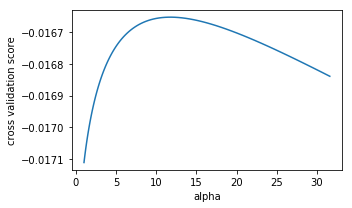

In [58]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
alphas = np.logspace(0, 1.5, 100)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Ridge(alpha, normalize=False), x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [59]:
ridge_2 = linear_model.Ridge(alphas[np.argmax(scores)], normalize=False)
ridge_2.fit(x_train, y_train)
print(alphas[np.argmax(scores)])
print(ridge_2.score(x_train, y_train))

11.9057723938
0.914370816992


In [38]:
model_to_csv(ridge_2, x_test, test_ID, 'mul_ridge_2.csv')

In [40]:
coef_ridge_2 = pd.concat([pd.Series(ridge_2.coef_, name='coef'), pd.Series(x_train.columns,
                                                                                     name='Features')], axis=1)
coef_ridge_2.loc[abs(coef_ridge_2.coef) > 0.05,:].sort_values(by='coef', ascending=False)

,coef,Features
68,0.066962,Neighborhood_Crawfor
75,0.066142,Neighborhood_NridgHt
1,0.064017,LotArea
82,0.063864,Condition1_Norm
47,0.062408,MSZoning_RL
26,0.061589,GarageCars
2,0.060614,OverallQual
145,0.059713,SaleCondition_Normal
46,0.057866,MSZoning_FV
98,0.057595,Exterior1st_BrkFace


#############################################
## Multi Linear Ridge Model_3
#############################################

This is a follow from Ridge Model_2. 

In [ ]:
#plt.scatter([log(x) if x>0 else 0 for x in x_train['TotalBsmtFinSF']], y_train)

In [ ]:
#call the impute function in process module
one_hot_df = impute_multi_2(all_data)

In [ ]:
#label encode the ordered category 
one_hot_df = label_en(one_hot_df)
one_hot_df.head()

In [ ]:
#use one_hot encoding to dummify all the category data
one_hot_df = pd.get_dummies(one_hot_df, drop_first=True, dummy_na=True)

In [ ]:
#list of features that needs to be transformed sqrt.
sqrt_tran_list = ['GrLivArea','MasVnrArea','BsmtFinSF1', 'LotFrontage', 'LotArea','GarageArea',
                 'TotalBsmtFinSF','LowQualFinSF']
sqrt_tran(one_hot_df,sqrt_tran_list)

In [ ]:
#use func drop_minor to delete the minor class(<70) in dumified feature
one_hot_df.drop(drop_minor(one_hot_df), axis=1, inplace=True)

In [ ]:
#choose the first 1460 as train sample
x_train = one_hot_df.iloc[list(range(1460)),:]
#choose the first 1460 as train sample
x_test = one_hot_df.iloc[list(range(1460,2919)),:]
#y_train transformation. y=log(y-MiscValue)
y_train = [log((y_train_raw[i] - x_train_raw['MiscVal'][i])) for i in range(len(y_train_raw))]

In [ ]:
alphas = np.logspace(-0.5, 1.5, 100)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Ridge(alpha, normalize=False), x_train, y_train, cv=5,
                          scoring='neg_mean_squared_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [ ]:
ridge_3 = linear_model.Ridge(alphas[np.argmax(scores)], normalize=False)
ridge_3.fit(x_train, y_train)
print(ridge_3.score(x_train, y_train))
print(alphas[np.argmax(scores)])
model_to_csv(ridge_3, x_test, test_ID, 'mul_ridge_3.csv')

In [ ]:
coef_ridge_3 = pd.concat([pd.Series(ridge_3.coef_, name='coef'), pd.Series(x_train.columns,
                                                                                     name='Features')], axis=1)
coef_ridge_3.loc[coef_ridge_3.coef!=0,:].sort_values(by='coef', ascending=False).head()

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:4

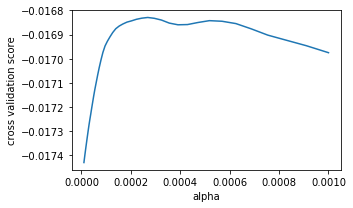

In [104]:
alphas = np.logspace(-5, -3, 50)

plt.figure(figsize=(5, 3))

scores = [cross_val_score(linear_model.Lasso(alpha, normalize=False), x_train, y_train, cv=5,
                          scoring='neg_mean_squared_error').mean() for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [105]:
lasso_3 = linear_model.Lasso(alphas[np.argmax(scores)], normalize=False)
lasso_3.fit(x_train, y_train)
print(lasso_3.score(x_train, y_train))
print(alphas[np.argmax(scores)])
model_to_csv(lasso_3, x_test, test_ID, 'mul_ridge_3.csv')

0.914608699956
0.000268269579528


/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [108]:
coef_lasso_3 = pd.concat([pd.Series(lasso_3.coef_, name='coef'), pd.Series(x_train.columns,
                                                                                     name='Features')], axis=1)
#coef_lasso_3.loc[coef_lasso_3.coef!=0,:].sort_values(by='coef', ascending=False)
coef_lasso_3.loc[abs(coef_lasso_3.coef) > 0.05,:].sort_values(by='coef', ascending=False)

,coef,Features
46,0.094208,MSZoning_FV
47,0.083330,MSZoning_RL
75,0.073371,Neighborhood_NridgHt
68,0.068136,Neighborhood_Crawfor
1,0.067443,LotArea
142,0.066819,SaleType_New
82,0.066764,Condition1_Norm
26,0.064287,GarageCars
98,0.063051,Exterior1st_BrkFace
145,0.060611,SaleCondition_Normal


# TREE Model

In [92]:
from sklearn import ensemble
RF = ensemble.RandomForestRegressor()
#dir(ensemble)

In [93]:
RF.set_params(oob_score=True, random_state=42)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [94]:
tree_m1 = RF.fit(x_train, y_train)

/Users/Strider/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [122]:
from sklearn.model_selection import GridSearchCV
grid_para_forest = [{
    "n_estimators": [100, 150, 200, 250, 300],
    "min_samples_leaf": range(1, 4),
    "min_samples_split": np.linspace(start=2, stop=20, num=10, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(RF, grid_para_forest, cv=5, n_jobs=-1, verbose=1)
%time grid_search_forest.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  5.9min finished


CPU times: user 7.2 s, sys: 1.05 s, total: 8.25 s
Wall time: 5min 57s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': range(1, 4), 'n_estimators': [100, 150, 200, 250, 300], 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [123]:
grid_search_forest.best_params_

{'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 250,
 'random_state': 42}

In [125]:
grid_search_forest.best_score_

0.87321701971269694

In [126]:
model_to_csv(grid_search_forest, x_test, test_ID, 'RF_1.csv')

In [127]:
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_train, grid_search_forest.predict(x_train)))

0.051461281826320315

# XGB Model

In [60]:
import xgboost as xgb
m_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                            learning_rate=0.05, max_depth=3,
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, silent=1,
                             nthread = -1)

In [61]:
m1 = m_xgb.fit(x_train, y_train)

In [24]:
m1.predict(x_test)

array([ 11.67912006,  11.99563313,  12.10760212, ...,  12.03518677,
        11.68349457,  12.33014774], dtype=float32)

In [25]:
model_to_csv(m1, x_test, test_ID, 'xgb1.csv')

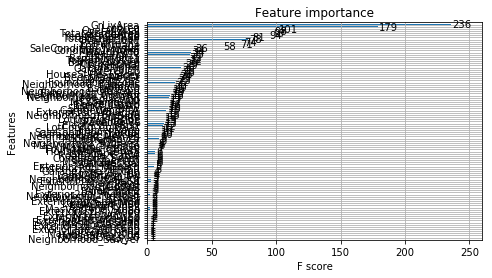

In [29]:

xgb.plot_importance(m1)

#############################################
## GB Model
############################################# 

In [ ]:
from sklearn import ensemble
gradientBoosting = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)

In [129]:
grid_para_forest = [{
    "criterion": ['friedman_mse', 'mse'],
    "max_depth": [4],
    "max_features": [4, 8, 16],
    "min_samples_split": np.linspace(start=2, stop=20, num=10, dtype=int),
    "random_state": [42]}]
grid_search_forest = model_selection.GridSearchCV(gradientBoosting, grid_para_forest, 
                                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train_train, y_train_train)

NameError: name 'model_selection' is not defined

#############################################
## Stack Model_4
#############################################

This is a follow from Ridge Model_2. 

In [78]:
from stacking import stacking_regression

In [109]:
y_pred = stacking_regression([ridge_2, m1, grid_search_forest], 
                    , x_train, np.array(y_train), x_test, n_folds=3)

metric: [mean_squared_error]

model 0: [Ridge]
    ----
    MEAN:   [0.01731802]

model 1: [XGBRegressor]
    ----
    MEAN:   [0.01670090]

model 2: [GridSearchCV]
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


    ----
    MEAN:   [0.02152974]



array([ 11.88827544,  11.97916303,  12.04194924, ...,  12.02034278,
        11.90339621,  12.13098192])

In [ ]:
y_pred =[]
for i in np.logspace(-1,0, 10):
    stacking_regression([ridge_2, m1, grid_search_forest],
                    linear_model.Lasso(alpha=0.1, normalize=False), x_train, np.array(y_train), x_test, n_folds=3)

In [112]:
alphas = np.logspace(-1,0, 10)

array([ 0.1       ,  0.12915497,  0.16681005,  0.21544347,  0.27825594,
        0.35938137,  0.46415888,  0.59948425,  0.77426368,  1.        ])

In [ ]:
alphas = np.logspace(-1,0, 10)